In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = (session.query(Measurement.date)
                      .order_by(Measurement.date.desc())
                      .first()
              )
recent_date[0]

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(recent_date[0], "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_earlier = most_recent_date - dt.timedelta(weeks=52)

# Perform a query to retrieve the data and precipitation scores
date_precip = (session.query(Measurement.date, Measurement.prcp)
                      .filter(Measurement.date > one_year_earlier)
                      .all()
              )

# Save the query results as a Pandas DataFrame and set the index to the date column
date_precip_df = (pd.DataFrame(date_precip, columns=["Date", "Precipitation"])
                    .set_index("Date")
                 ).groupby("Date").max()
date_precip_df.head(10)

,Precipitation
Date,
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
2016-08-29,0.90
2016-08-30,0.05
2016-08-31,2.46
2016-09-01,0.02
2016-09-02,0.19


In [11]:
# Sort the dataframe by date
date_precip_df = date_precip_df.sort_values(by="Date")
date_precip_df.head()

,Precipitation
Date,
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
2016-08-29,0.90


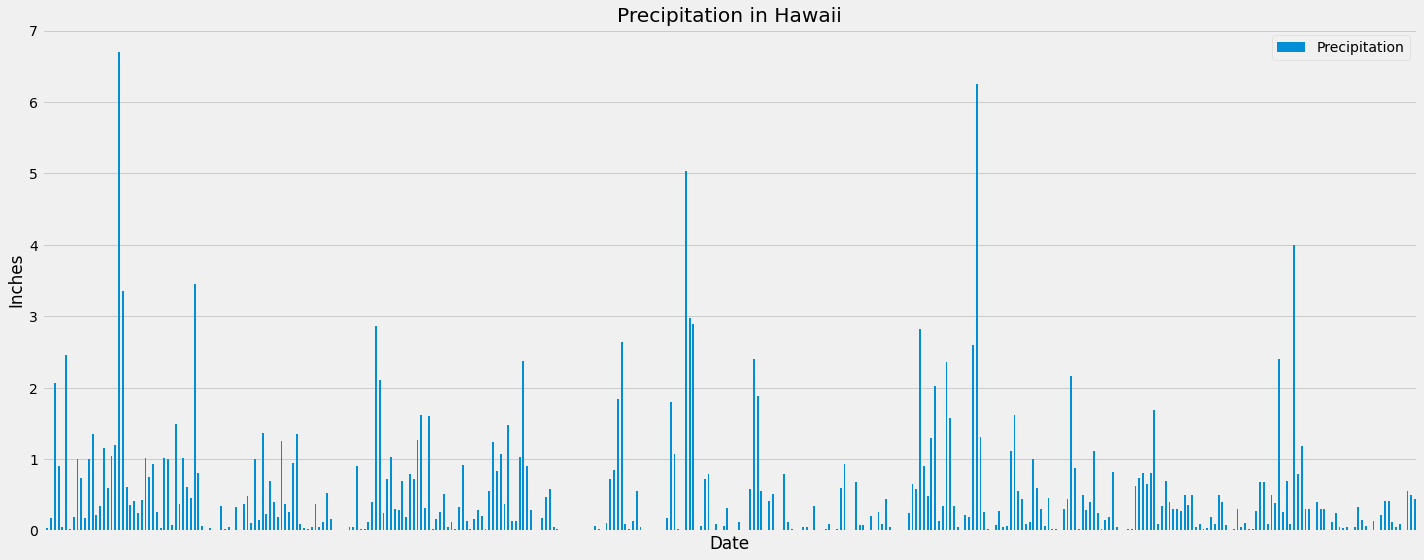

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
xticks=np.arange(len(date_precip_df),15,7)
date_precip_df.plot.bar(rot=90, figsize=(20,8))
plt.title("Precipitation in Hawaii")
plt.xticks(xticks)
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precip_df.agg(['min', 'max', 'sum', 'mean', 'count'])

,Precipitation
min,0.000000
max,6.700000
sum,186.530000
mean,0.512445
count,364.000000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (session.query(Station.name, Station.station, func.count(Station.name))
                          .filter(Station.station == Measurement.station)
                          .group_by(Station.name)
                          .order_by(func.count(Station.name).desc())
                          .all()
)
active_stations

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('PEARL CITY, HI US', 'USC00517948', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [16]:
active_stations[0][1]

'USC00519281'

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station=active_stations[0][1]
(temp_min, temp_max, temp_avg) = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
        .filter(Station.station == Measurement.station)
        .filter(Station.station == active_station)
        .first()
)
print(f"Station {active_station} min temp: {temp_min}, max temp: {temp_max}, average temp: {temp_avg:.1f}")

Station USC00519281 min temp: 54.0, max temp: 85.0, average temp: 71.7


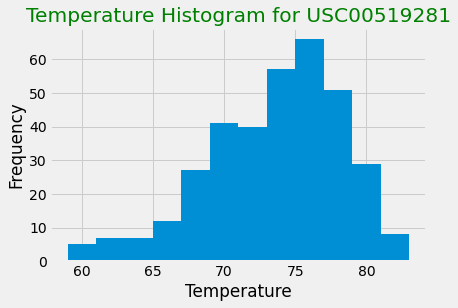

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_281 = (session.query(Measurement.tobs)
                    .filter(Station.station == Measurement.station)
                    .filter(Station.station == active_station)
                    .filter(Measurement.date > one_year_earlier)
                    .all()
            )
temps_list_281 = [temp[0] for temp in temps_281]
# temps_list_281[:10]
plt.hist(temps_list_281, bins=12)
plt.title(f"Temperature Histogram for {active_station}", color="green")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [19]:
# Close Session
session.close()